In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import numpy as np
import pandas as pd
import pdb

import sys
sys.path.append('../')
from testWN import testWN as twm

from tensorflow import keras
from sklearn.linear_model import LinearRegression

In [2]:
%matplotlib notebook

# Get network informations

In [3]:
inp_file = '../../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [4]:
cluster_labels = pd.read_json('cluster_labels.json')
pressure_factor = pd.read_json('pressure_factor.json')
n_clusters = 30

Get results:

In [5]:
file = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim/results_sim_14_try.pkl'
with open(file, 'rb') as f:
    results = pickle.load(f)

## Physical preprocessing:

### Junctions
Scale pressure for each node (similar to clustering)

In [6]:
junction_pressure_scaled = results.node['pressure'][node_names[2]]/pressure_factor.to_numpy()

In [7]:
jun_cl_press = junction_pressure_scaled.groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press.mean()
jun_cl_press_std = jun_cl_press.std()

jun_cl_demand = results.node['demand'][node_names[2]].groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_demand_sum = jun_cl_demand.sum()

jun_cl_qual = results.node['quality'][node_names[2]].diff(axis=0).groupby(cluster_labels.loc['quality'], axis=1)
qual_cl_qual_mean = jun_cl_qual.mean()
qual_cl_qual_std = jun_cl_qual.std()

<IPython.core.display.Javascript object>


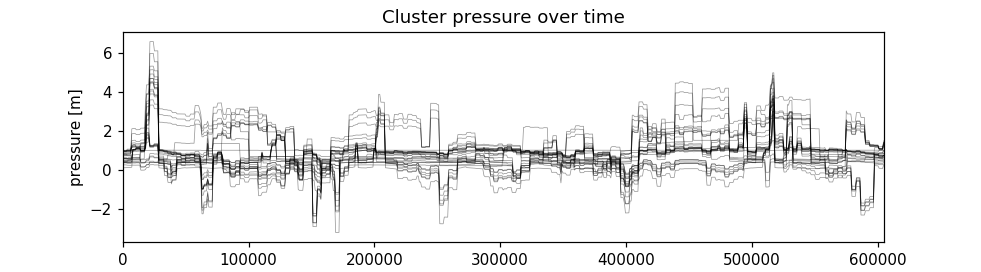

In [8]:
fig, ax = plt.subplots(figsize=(9,2.5))
jun_cl_press_mean.plot(ax=ax, legend=False, linewidth=0.5, color='k', alpha=0.4)
ax.set_xlabel('time [s]')
ax.set_ylabel('pressure [m]')
ax.set_title('Cluster pressure over time')
plt.show()

### Tanks

In [9]:
tank_press = results.node['pressure'][node_names[0]]
# Subtract tank elevation from tank head to obtain tank_level
tank_level = results.node['head'][node_names[0]]-nw_node_df[node_names[0]].loc['elevation']

tank_qual = results.node['quality'][node_names[0]]

<IPython.core.display.Javascript object>


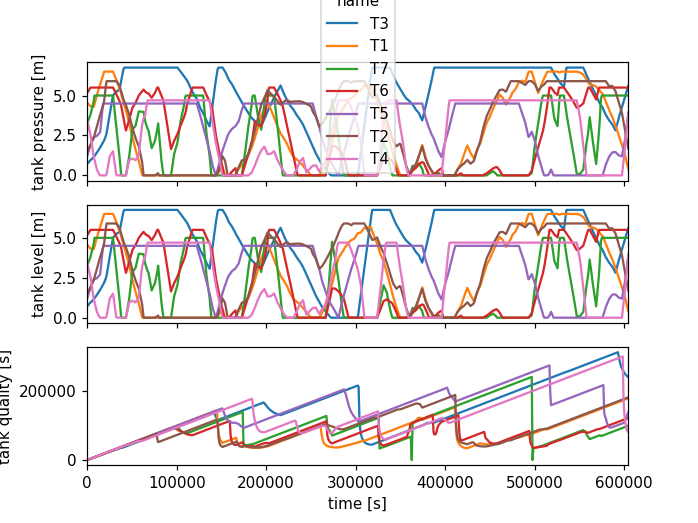

Text(0.5, 0, 'time [s]')

In [10]:
fig, ax = plt.subplots(3,1, sharex=True,)
tank_press.plot(ax=ax[0])
ax[0].set_ylabel('tank pressure [m]')
tank_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('tank level [m]')
tank_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('tank quality [s]')
ax[2].set_xlabel('time [s]')

### Reservoirs

In [11]:
reservoir_press = results.node['pressure'][node_names[1]]
reservoir_level = results.node['head'][node_names[1]]-nw_node_df[node_names[1]].loc['elevation']

reservoir_qual = results.node['quality'][node_names[1]]

<IPython.core.display.Javascript object>


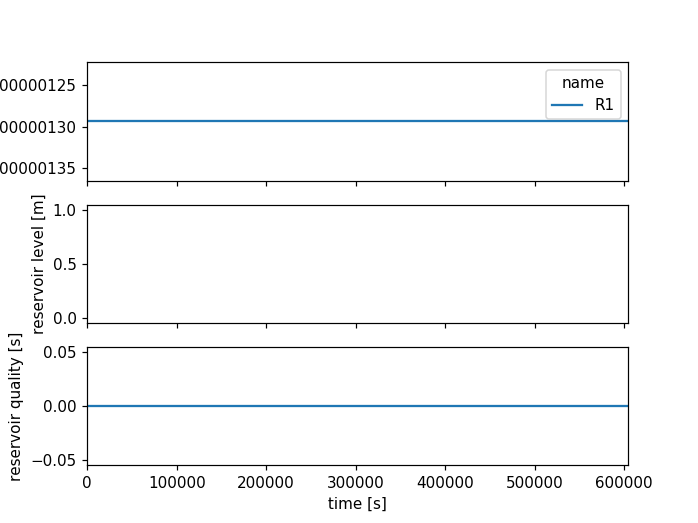

Text(0.5, 0, 'time [s]')

In [12]:
fig, ax = plt.subplots(3,1, sharex=True,)
reservoir_press.plot(ax=ax[0])
ax[0].set_ylabel('reservoir pressure [m]')
reservoir_level.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('reservoir level [m]')
reservoir_qual.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('reservoir quality [s]')
ax[2].set_xlabel('time [s]')

### Pumps

In [13]:
head_pump_speed = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['link_type'] == 'Pump']]

<IPython.core.display.Javascript object>


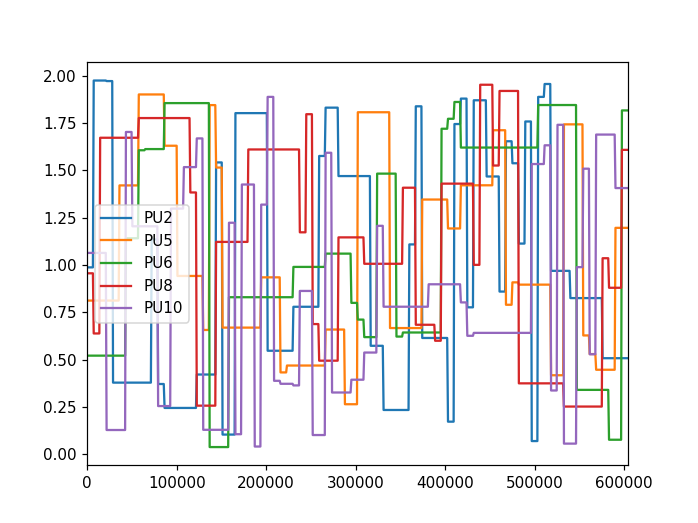

In [14]:
fig, ax = plt.subplots()
head_pump_speed.plot(ax=ax)

### Valves

In [15]:
PRValve_dp = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'PRV']]
TCValve_throttle = results.link['setting'][nw_link_df.keys()[nw_link_df.loc['valve_type'] == 'TCV']]

<IPython.core.display.Javascript object>


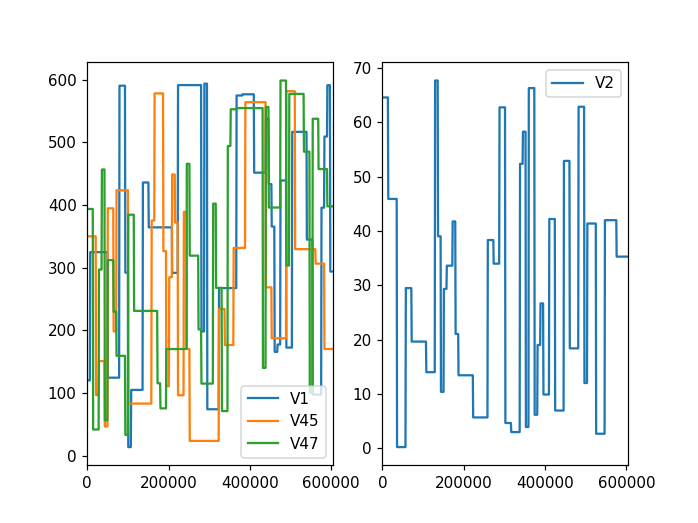

In [16]:
fig, ax = plt.subplots(1,2)
PRValve_dp.plot(ax=ax[0])
TCValve_throttle.plot(ax=ax[1])

## Neural Network Pre-Processing
### States and Inputs

In [143]:
state_dict = {'jun_cl_press_mean': jun_cl_press_mean,
              # 'jun_cl_press_std': jun_cl_press_std,
              # 'dqual_cl_press_mean': dqual_cl_press_mean,
              # 'dqual_cl_press_std': dqual_cl_press_std,
              'tank_press': tank_press,
              # 'tank_level': tank_level,
              # 'tank_qual': tank_qual,
              # 'reservoir_press': reservoir_press,
              # 'reservoir_level': reservoir_level,
              # 'reservoir_qual': reservoir_qual,
              }

sys_states = pd.concat(state_dict.values(), axis=1, keys=state_dict.keys())


input_dict = {'head_pump_speed': head_pump_speed,
              'PRValve_dp': PRValve_dp,
              'TCValve_throttle': TCValve_throttle,
              'jun_cl_demand_sum': jun_cl_demand_sum}

sys_inputs = pd.concat(input_dict.values(), axis=1, keys=input_dict.keys())

### Neural Network I/O

In [144]:
dstates = sys_states.diff(axis=0)
dstates.head(3)

jun_cl_press_mean                                                    \
                     0         1         2         3         4         5   
0                  NaN       NaN       NaN       NaN       NaN       NaN   
900          -0.001483 -0.000504  0.000702 -0.000655 -0.000779  0.001104   
1800         -0.001472 -0.000493  0.000700 -0.000641 -0.000763  0.001098   

                                              ...                      \
             6         7         8         9  ...        27        28   
0          NaN       NaN       NaN       NaN  ...       NaN       NaN   
900  -0.000672 -0.001717  0.001536  0.000453  ...  0.001013 -0.000878   
1800 -0.000663 -0.001716  0.001532  0.000453  ...  0.001007 -0.000866   

               tank_press                                                    \
            29         T3        T1        T7        T6        T5        T2   
0          NaN        NaN       NaN       NaN       NaN       NaN       NaN   
900  -0.000703   0.058313 -0.061676  0.137564  0.081223  0.165376  0.103854   
1800 -0.000689   0.058396 -0.060926  0.136698  0.081344  0.164818  0.102608   

                
            T4  
0          NaN  
900  -0.228926  
1800 -0.228925  

[3 rows x 37 columns]

In [145]:
dstates_next = dstates.shift(-1, axis=0)
dstates_next.head(3)

jun_cl_press_mean                                                    \
                     0         1         2         3         4         5   
0            -0.001483 -0.000504  0.000702 -0.000655 -0.000779  0.001104   
900          -0.001472 -0.000493  0.000700 -0.000641 -0.000763  0.001098   
1800         -0.001418 -0.000486  0.000697 -0.000632 -0.000753  0.001091   

                                              ...                      \
             6         7         8         9  ...        27        28   
0    -0.000672 -0.001717  0.001536  0.000453  ...  0.001013 -0.000878   
900  -0.000663 -0.001716  0.001532  0.000453  ...  0.001007 -0.000866   
1800 -0.000655 -0.001689  0.001527  0.000451  ...  0.001001 -0.000855   

               tank_press                                                    \
            29         T3        T1        T7        T6        T5        T2   
0    -0.000703   0.058313 -0.061676  0.137564  0.081223  0.165376  0.103854   
900  -0.000689   0.058396 -0.060926  0.136698  0.081344  0.164818  0.102608   
1800 -0.000679   0.058471 -0.060187  0.135843  0.081465  0.164278  0.101338   

                
            T4  
0    -0.228926  
900  -0.228925  
1800 -0.228916  

[3 rows x 37 columns]

In [146]:
nn_output = dstates_next
nn_output = sys_states.shift(-1,axis=0)

In [150]:
nn_input_dict = {'sys_states': sys_states,
                 'sys_inputs': sys_inputs}
nn_input = pd.concat(nn_input_dict.values(), axis=1, keys=nn_input_dict.keys())

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 76)


NARX model structure?

In [151]:
if True:
    n_arx = 5
    arx_input = []
    for i in range(n_arx):
        arx_input.append(nn_input.shift(i, axis=0))

    arx_input = pd.concat(arx_input, keys=np.arange(n_arx), names=['NARX', 'type', 'name', 'index'], axis=1)
    nn_input = arx_input
print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (673, 380)


In [152]:
nn_input.head(3)

NARX                  0                                                    \
type         sys_states                                                     
name  jun_cl_press_mean                                                     
index                0         1         2         3         4         5    
0              0.361217  0.942634  0.580960  0.946468  0.903360  0.491254   
900            0.359735  0.942131  0.581662  0.945813  0.902581  0.492358   
1800           0.358263  0.941637  0.582362  0.945172  0.901817  0.493456   

NARX                                           ...                 4          \
type                                           ...        sys_inputs           
name                                           ... jun_cl_demand_sum           
index        6         7         8         9   ...                20  21  22   
0      0.998509  0.255970  0.576981  0.488532  ...               NaN NaN NaN   
900    0.997837  0.254253  0.578518  0.488985  ...               NaN NaN NaN   
1800   0.997174  0.252537  0.580050  0.489438  ...               NaN NaN NaN   

NARX                               
type                               
name                               
index  23  24  25  26  27  28  29  
0     NaN NaN NaN NaN NaN NaN NaN  
900   NaN NaN NaN NaN NaN NaN NaN  
1800  NaN NaN NaN NaN NaN NaN NaN  

[3 rows x 380 columns]

Check if NARX structure works:

In [153]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(5)

NARX,0,1,2,3,4
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
0,0.361217,NaN,NaN,NaN,NaN
900,0.359735,0.361217,NaN,NaN,NaN
1800,0.358263,0.359735,0.361217,NaN,NaN
2700,0.356845,0.358263,0.359735,0.361217,NaN
3600,0.329629,0.356845,0.358263,0.359735,0.361217


Filter inputs and outputs:

In [154]:
# Filter nan:
output_filter = nn_output.isnull().any(axis=1)
if output_filter.any():
    nn_input = nn_input[~output_filter]
    nn_output = nn_output[~output_filter]

input_filter = nn_input.isnull().any(axis=1)
if input_filter.any():
    nn_input = nn_input[~input_filter]
    nn_output = nn_output[~input_filter]

print('n_samples, n_feat = {}'.format(nn_input.shape))

n_samples, n_feat = (668, 380)


In [155]:
nn_input.xs(('sys_states',slice(0)),level=('type','index'), axis=1).head(3)

NARX,0,1,2,3,4
name,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean,jun_cl_press_mean
3600,0.329629,0.356845,0.358263,0.359735,0.361217
4500,0.327420,0.329629,0.356845,0.358263,0.359735
5400,0.325200,0.327420,0.329629,0.356845,0.358263


In [156]:
pd.DataFrame(nn_output['jun_cl_press_mean',0]).head(3)

,jun_cl_press_mean
,0
3600,0.327420
4500,0.325200
5400,0.322979


### Normalize Data:

In [157]:
input_offset = nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

# Neural Network

## Create Model

In [158]:
n_layer = 3
n_units = 100
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']
model_param['l1_regularizer'] = (n_layer) * [l1_regularizer]

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           # kernel_regularizer=regularizers.l1(model_param['l1_regularizer'][i])(layer_list[i])
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 380)]             0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               38100     
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_21 (Dense)             (None, 37)                3737      
Total params: 51,937
Trainable params: 51,937
Non-trainable params: 0
_________________________________________________________________


## Train model

In [159]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=optim,
              loss='mse')

In [160]:
history = model.fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy(), batch_size=67, epochs=1000)

Train on 668 samples
Epoch 1/1000
668/668 [==============================] - 1s 901us/sample - loss: 0.1689
Epoch 2/1000
668/668 [==============================] - 0s 96us/sample - loss: 0.0590
Epoch 3/1000
668/668 [==============================] - 0s 70us/sample - loss: 0.0372
Epoch 4/1000
668/668 [==============================] - 0s 76us/sample - loss: 0.0276
Epoch 5/1000
668/668 [==============================] - 0s 92us/sample - loss: 0.0223
Epoch 6/1000
668/668 [==============================] - 0s 66us/sample - loss: 0.0189
Epoch 7/1000
668/668 [==============================] - 0s 63us/sample - loss: 0.0167
Epoch 8/1000
668/668 [==============================] - 0s 69us/sample - loss: 0.0150
Epoch 9/1000
668/668 [==============================] - 0s 81us/sample - loss: 0.0139
Epoch 10/1000
668/668 [==============================] - 0s 108us/sample - loss: 0.0128
Epoch 11/1000
668/668 [==============================] - 0s 110us/sample - loss: 0.0120
Epoch 12/1000
668/668 [=====

668/668 [==============================] - 0s 126us/sample - loss: 0.0045
Epoch 95/1000
668/668 [==============================] - 0s 78us/sample - loss: 0.0046
Epoch 96/1000
668/668 [==============================] - 0s 76us/sample - loss: 0.0046
Epoch 97/1000
668/668 [==============================] - 0s 98us/sample - loss: 0.0046
Epoch 98/1000
668/668 [==============================] - 0s 83us/sample - loss: 0.0044
Epoch 99/1000
668/668 [==============================] - 0s 80us/sample - loss: 0.0044
Epoch 100/1000
668/668 [==============================] - 0s 108us/sample - loss: 0.0044
Epoch 101/1000
668/668 [==============================] - 0s 89us/sample - loss: 0.0043
Epoch 102/1000
668/668 [==============================] - 0s 62us/sample - loss: 0.0042
Epoch 103/1000
668/668 [==============================] - 0s 61us/sample - loss: 0.0046
Epoch 104/1000
668/668 [==============================] - 0s 60us/sample - loss: 0.0045
Epoch 105/1000
668/668 [==========================

668/668 [==============================] - 0s 86us/sample - loss: 0.0026
Epoch 188/1000
668/668 [==============================] - 0s 80us/sample - loss: 0.0027
Epoch 189/1000
668/668 [==============================] - 0s 66us/sample - loss: 0.0028
Epoch 190/1000
668/668 [==============================] - 0s 78us/sample - loss: 0.0029
Epoch 191/1000
668/668 [==============================] - 0s 71us/sample - loss: 0.0028
Epoch 192/1000
668/668 [==============================] - 0s 60us/sample - loss: 0.0027
Epoch 193/1000
668/668 [==============================] - 0s 59us/sample - loss: 0.0027
Epoch 194/1000
668/668 [==============================] - 0s 59us/sample - loss: 0.0025
Epoch 195/1000
668/668 [==============================] - 0s 74us/sample - loss: 0.0027
Epoch 196/1000
668/668 [==============================] - 0s 64us/sample - loss: 0.0028
Epoch 197/1000
668/668 [==============================] - 0s 60us/sample - loss: 0.0026
Epoch 198/1000
668/668 [=======================

668/668 [==============================] - 0s 84us/sample - loss: 0.0018
Epoch 281/1000
668/668 [==============================] - 0s 81us/sample - loss: 0.0017
Epoch 282/1000
668/668 [==============================] - 0s 63us/sample - loss: 0.0017
Epoch 283/1000
668/668 [==============================] - 0s 59us/sample - loss: 0.0017
Epoch 284/1000
668/668 [==============================] - 0s 56us/sample - loss: 0.0017
Epoch 285/1000
668/668 [==============================] - 0s 57us/sample - loss: 0.0017
Epoch 286/1000
668/668 [==============================] - 0s 71us/sample - loss: 0.0017
Epoch 287/1000
668/668 [==============================] - 0s 69us/sample - loss: 0.0017
Epoch 288/1000
668/668 [==============================] - 0s 55us/sample - loss: 0.0017
Epoch 289/1000
668/668 [==============================] - 0s 68us/sample - loss: 0.0018
Epoch 290/1000
668/668 [==============================] - 0s 65us/sample - loss: 0.0018
Epoch 291/1000
668/668 [=======================

668/668 [==============================] - 0s 69us/sample - loss: 0.0012
Epoch 374/1000
668/668 [==============================] - 0s 66us/sample - loss: 0.0012
Epoch 375/1000
668/668 [==============================] - 0s 72us/sample - loss: 0.0012
Epoch 376/1000
668/668 [==============================] - 0s 83us/sample - loss: 0.0013
Epoch 377/1000
668/668 [==============================] - 0s 69us/sample - loss: 0.0013
Epoch 378/1000
668/668 [==============================] - 0s 77us/sample - loss: 0.0013
Epoch 379/1000
668/668 [==============================] - 0s 63us/sample - loss: 0.0012
Epoch 380/1000
668/668 [==============================] - 0s 74us/sample - loss: 0.0012
Epoch 381/1000
668/668 [==============================] - 0s 77us/sample - loss: 0.0012
Epoch 382/1000
668/668 [==============================] - 0s 70us/sample - loss: 0.0012
Epoch 383/1000
668/668 [==============================] - 0s 77us/sample - loss: 0.0012
Epoch 384/1000
668/668 [=======================

668/668 [==============================] - 0s 67us/sample - loss: 9.6131e-04
Epoch 465/1000
668/668 [==============================] - 0s 58us/sample - loss: 9.1699e-04
Epoch 466/1000
668/668 [==============================] - 0s 59us/sample - loss: 9.6272e-04
Epoch 467/1000
668/668 [==============================] - 0s 53us/sample - loss: 9.3429e-04
Epoch 468/1000
668/668 [==============================] - 0s 47us/sample - loss: 8.8939e-04
Epoch 469/1000
668/668 [==============================] - 0s 52us/sample - loss: 9.4845e-04
Epoch 470/1000
668/668 [==============================] - 0s 72us/sample - loss: 9.5135e-04
Epoch 471/1000
668/668 [==============================] - 0s 58us/sample - loss: 9.5602e-04
Epoch 472/1000
668/668 [==============================] - 0s 90us/sample - loss: 9.2113e-04
Epoch 473/1000
668/668 [==============================] - 0s 89us/sample - loss: 9.1753e-04
Epoch 474/1000
668/668 [==============================] - 0s 110us/sample - loss: 9.6266e-04
Ep

668/668 [==============================] - 0s 74us/sample - loss: 7.0549e-04
Epoch 554/1000
668/668 [==============================] - 0s 76us/sample - loss: 7.0477e-04
Epoch 555/1000
668/668 [==============================] - 0s 67us/sample - loss: 7.0735e-04
Epoch 556/1000
668/668 [==============================] - 0s 58us/sample - loss: 6.9329e-04
Epoch 557/1000
668/668 [==============================] - 0s 56us/sample - loss: 6.6934e-04
Epoch 558/1000
668/668 [==============================] - 0s 58us/sample - loss: 6.9908e-04
Epoch 559/1000
668/668 [==============================] - 0s 73us/sample - loss: 6.8884e-04
Epoch 560/1000
668/668 [==============================] - 0s 58us/sample - loss: 6.7084e-04
Epoch 561/1000
668/668 [==============================] - 0s 60us/sample - loss: 6.6013e-04
Epoch 562/1000
668/668 [==============================] - 0s 59us/sample - loss: 7.0564e-04
Epoch 563/1000
668/668 [==============================] - 0s 70us/sample - loss: 7.6804e-04
Epo

668/668 [==============================] - 0s 77us/sample - loss: 6.2982e-04
Epoch 643/1000
668/668 [==============================] - 0s 55us/sample - loss: 6.1490e-04
Epoch 644/1000
668/668 [==============================] - 0s 60us/sample - loss: 5.6804e-04
Epoch 645/1000
668/668 [==============================] - 0s 63us/sample - loss: 6.4077e-04
Epoch 646/1000
668/668 [==============================] - 0s 68us/sample - loss: 6.8214e-04
Epoch 647/1000
668/668 [==============================] - 0s 68us/sample - loss: 7.0262e-04
Epoch 648/1000
668/668 [==============================] - 0s 51us/sample - loss: 7.0029e-04
Epoch 649/1000
668/668 [==============================] - 0s 66us/sample - loss: 6.6402e-04
Epoch 650/1000
668/668 [==============================] - 0s 66us/sample - loss: 6.9721e-04
Epoch 651/1000
668/668 [==============================] - 0s 84us/sample - loss: 6.4964e-04
Epoch 652/1000
668/668 [==============================] - 0s 68us/sample - loss: 6.1260e-04
Epo

668/668 [==============================] - 0s 60us/sample - loss: 5.0885e-04
Epoch 732/1000
668/668 [==============================] - 0s 83us/sample - loss: 5.3286e-04
Epoch 733/1000
668/668 [==============================] - 0s 59us/sample - loss: 5.1014e-04
Epoch 734/1000
668/668 [==============================] - 0s 55us/sample - loss: 4.7420e-04
Epoch 735/1000
668/668 [==============================] - 0s 76us/sample - loss: 4.5500e-04
Epoch 736/1000
668/668 [==============================] - 0s 66us/sample - loss: 4.6982e-04
Epoch 737/1000
668/668 [==============================] - 0s 77us/sample - loss: 4.7616e-04
Epoch 738/1000
668/668 [==============================] - 0s 76us/sample - loss: 4.8995e-04
Epoch 739/1000
668/668 [==============================] - 0s 70us/sample - loss: 4.9472e-04
Epoch 740/1000
668/668 [==============================] - 0s 72us/sample - loss: 4.4084e-04
Epoch 741/1000
668/668 [==============================] - 0s 77us/sample - loss: 4.4188e-04
Epo

668/668 [==============================] - 0s 67us/sample - loss: 3.8600e-04
Epoch 821/1000
668/668 [==============================] - 0s 45us/sample - loss: 3.9908e-04
Epoch 822/1000
668/668 [==============================] - 0s 60us/sample - loss: 3.8037e-04
Epoch 823/1000
668/668 [==============================] - 0s 65us/sample - loss: 3.7833e-04
Epoch 824/1000
668/668 [==============================] - 0s 64us/sample - loss: 3.5158e-04
Epoch 825/1000
668/668 [==============================] - 0s 78us/sample - loss: 3.6398e-04
Epoch 826/1000
668/668 [==============================] - 0s 75us/sample - loss: 3.6221e-04
Epoch 827/1000
668/668 [==============================] - 0s 75us/sample - loss: 3.5112e-04
Epoch 828/1000
668/668 [==============================] - 0s 70us/sample - loss: 4.0469e-04
Epoch 829/1000
668/668 [==============================] - 0s 75us/sample - loss: 3.9872e-04
Epoch 830/1000
668/668 [==============================] - 0s 74us/sample - loss: 3.8757e-04
Epo

668/668 [==============================] - 0s 98us/sample - loss: 3.6793e-04
Epoch 910/1000
668/668 [==============================] - 0s 63us/sample - loss: 3.4905e-04
Epoch 911/1000
668/668 [==============================] - 0s 64us/sample - loss: 3.7080e-04
Epoch 912/1000
668/668 [==============================] - 0s 50us/sample - loss: 3.6768e-04
Epoch 913/1000
668/668 [==============================] - 0s 49us/sample - loss: 3.4784e-04
Epoch 914/1000
668/668 [==============================] - 0s 48us/sample - loss: 3.7798e-04
Epoch 915/1000
668/668 [==============================] - 0s 53us/sample - loss: 3.7271e-04
Epoch 916/1000
668/668 [==============================] - 0s 48us/sample - loss: 3.5733e-04
Epoch 917/1000
668/668 [==============================] - 0s 50us/sample - loss: 3.7258e-04
Epoch 918/1000
668/668 [==============================] - 0s 58us/sample - loss: 3.8305e-04
Epoch 919/1000
668/668 [==============================] - 0s 50us/sample - loss: 3.8241e-04
Epo

668/668 [==============================] - 0s 74us/sample - loss: 2.7406e-04
Epoch 999/1000
668/668 [==============================] - 0s 64us/sample - loss: 3.0603e-04
Epoch 1000/1000
668/668 [==============================] - 0s 73us/sample - loss: 3.4673e-04


## Evaluate model

In [183]:
class narx_simulator:
    def __init__(self, model, n_arx, input_scaling, output_scaling, input_offset, output_offset, nn_in_0):
        self.model = model
        self.n_arx = n_arx
        
        self.input_scaling = input_scaling.to_numpy()
        self.output_scaling = output_scaling.to_numpy()
        self.input_offset = input_offset.to_numpy()
        self.output_offset = output_offset.to_numpy()
        
        self.nn_in = nn_in_0
        
        self.t0 = nn_in_0.index[0]
        self.dt = 900
        
    def prepare_next_iter(self):  
        # Update time
        t_prev = self.t0
        self.t0 += self.dt
        # Create new row in results table:
        self.nn_in.append(pd.Series(name=self.t0))
        # Update current states:
        #self.nn_in.loc[self.t0,(0,'sys_states')] = self.next_state.loc[t_prev].to_numpy()
        self.nn_in.loc[self.t0,(0,'sys_states')] = self.next_state


        # Update previous states + inputs for NARX structure
        for k in range(n_arx-1):
            self.nn_in.loc[self.t0,(k+1,'sys_states')] = self.nn_in.loc[t_prev,(k,'sys_states')].to_numpy()        
            self.nn_in.loc[self.t0,(k+1,'sys_inputs')] = self.nn_in.loc[t_prev,(k,'sys_inputs')].to_numpy()
        
    def eval_nn(self):
        # Scale input:
        nn_in_scaled = (self.nn_in.tail(1)-self.input_offset)/self.input_scaling
        # Evaluate NN:
        nn_out_scaled = self.model.predict(nn_in_scaled.to_numpy())
        # Scale output:
        nn_out = nn_out_scaled*self.output_scaling+self.output_offset
        # Output is difference from current to next state. Calculate next state:
#         self.next_state = self.nn_in[0,'sys_states'].tail(1) + nn_out
        self.next_state = nn_out.flatten()
        
    def next_step(self, sys_inputs_now):
        self.nn_in.loc[self.t0,(0,'sys_inputs')] = sys_inputs_now.to_numpy()
        
        self.eval_nn()
        
        self.prepare_next_iter()
        

In [184]:
nsim = narx_simulator(model, 5, input_scaling, output_scaling, input_offset, output_offset, nn_input.head(1))

In [167]:
for k in range(50):
    sys_inputs_now = nn_input.loc[nsim.t0,(0,'sys_inputs')]
    nsim.next_step(sys_inputs_now)

<IPython.core.display.Javascript object>


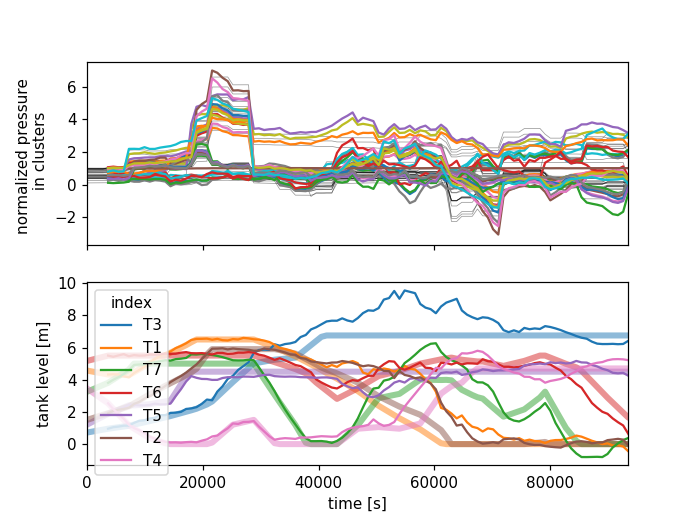

Text(0.5, 0, 'time [s]')

In [173]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
nsim.nn_in[0,'sys_states', 'jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
nsim.nn_in[0,'sys_states', 'tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, nsim.nn_in.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')

# Linear Model

In [176]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [185]:
nsim_lin = narx_simulator(linear_reg, 5, input_scaling, output_scaling, input_offset, output_offset, nn_input.head(1))

In [186]:
for k in range(50):
    sys_inputs_now = nn_input.loc[nsim_lin.t0,(0,'sys_inputs')]
    nsim_lin.next_step(sys_inputs_now)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<IPython.core.display.Javascript object>


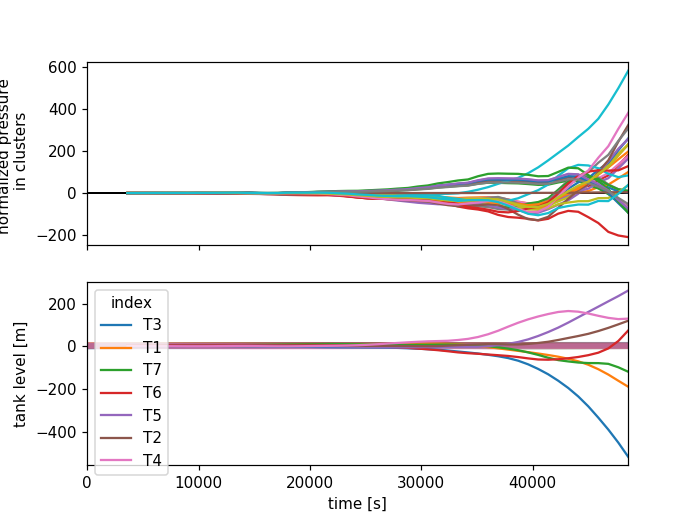

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning:

indexing past lexsort depth may impact performance.



Text(0.5, 0, 'time [s]')

In [187]:
fig, ax = plt.subplots(2,1, sharex=True)

jun_cl_press_mean.plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
nsim_lin.nn_in[0,'sys_states', 'jun_cl_press_mean'].plot(ax=ax[0], legend=False)

tank_press.plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
nsim_lin.nn_in[0,'sys_states', 'tank_press'].plot(ax=ax[1])

ax[0].set_xlim(0, nsim_lin.nn_in.index.max())

ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[1].set_xlabel('time [s]')